**Note:** This notebook is written in the Julia language, so the cells can't be
  executed in Google Colab. If you want to verify that the notebook works, I
  recommend [JuliaBox](https://juliabox.com/) or testing locally. The syntax is
  very similar to Python and MATLAB. Note in particular the dot syntax used to
  perform elementwise operations ( `f.(x)` applies `f` to all elements of `x` ),
  that indices start at 1 and that the last statement of all functions is returned
  automatically.

# **Lab 5: Ordinary Differential Equations**
**Anders Ågren Thuné**

# **Abstract**

# **About the code**

In [1]:
"""
DD2363 Methods in Scientific Computing,
KTH Royal Institute of Technology, Stockholm, Sweden.
"""

# Copyright (C) 2019
# Anders Ågren Thuné (athune@kth.se)
# Johan Hoffman (jhoffman@kth.se)

# Code written by Anders Ågren Thuné based on the template by Johan Hoffman.

# This file is part of the course DD2363 Methods in Scientific Computing
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

"DD2363 Methods in Scientific Computing,\nKTH Royal Institute of Technology, Stockholm, Sweden.\n"

# **Set up environment**

In [25]:
using LinearAlgebra
using Plots
pyplot()

Plots.PyPlotBackend()

# **Introduction**

Differential equations are often used to model a wide variety of natural and
physical systems, as they naturally encode the mechanics of change. An ordinary
differential equation is an equation in a single function $u$ and its
derivatives. In case higher order derivatives are involved, the equation can be
reformulated as a *system* of first-order differential equations.

A common type of problem is where some initial value $u_0$ is given, and the
value at time $T$ is sought. These problems can be solved using time-stepping
methods, which estimate the value at each point in time using the previous
value, starting from the given value and stepping forward. There are a number of
types of such methods with different *accuracy* and *stability* properties,
where the accuracy of a method indicates how the error changes with respect to
the granularity of the time discretization and the stability indicates how
robust a method is using timesteps of arbitrary length.

In this report, a function using the theta method for solving initial value
problems is implemented both for scalar problems and for systems of ordinary
differential equations. In addition, this solver is used to solve the
Lotka-Volterra equations describing population change, and the parameters
affecting the model are analyzed.

# **Methods**

In [142]:
"""
Calculate f'(x) using a central difference.
"""
centdiff(f, x, h = 1e-5) = (f(x+h) - f(x-h))/2h

"""
Calculate J(f)(p). Modifies the argument jac in place.
Based on @bozzato's implementation for lab 3.
"""
function filljacobian!(jac, f, p, h = 1e-5)
    p1 = p
    p2 = copy(p1)
    for i in 1:length(p)
        p1[i] += h
        p2[i] -= h

        jac[:,i] .= (f(p1) - f(p2)) / 2h

        p1[i] -= h
        p2[i] += h
    end
end

"""
Compute x such that f(x) = 0 using Newton's method.
"""
function newton(f, x0::Float64, TOL = 1e-5)
    x = x0
    h = Inf
    while abs(h) > TOL
        h = f(x)/centdiff(f, x)
        x -= h
    end
    x
end

function newton(f, x0::Vector{Float64}, TOL = 1e-5)
    n = length(x0); x = copy(x0); δf = zeros(n, n); h = Inf*ones(n)
    while norm(h) > TOL
        filljacobian!(δf, f, x)
        h .= δf\f(x)
        x .-= h
    end
    x
end

newton (generic function with 9 methods)

In [143]:
"""
Solve an IVP given f(u(t), t), a list of times [t0, t1, ..., tn], and a starting value u0
using a theta method with theta = θ. Newton's method is used to obtain the new value of
Un in each step. Works for both scalar problems and systems of ODEs.
"""
function thetamethod(f, ts, u0, θ, TOL = 1e-5)
    U = u0
    ks = diff(ts)

    results = zeros(length(ts)-1, length(u0))

    for i in 2:length(ts)
        U .= newton(x -> U + ks[i-1]*((1.0-θ)*f(x, ts[i]) + θ*f(U,ts[i-1])) - x, U)
        results[i-1,:] .= U
    end
    results
end

thetamethod

# **Results**

In [144]:
α = 0.1; β = 0.02; γ = 0.7; δ = 0.1

# The system
f(xy, t) = [α*xy[1] - β*xy[1]*xy[2];
            δ*xy[1]*xy[2] - γ*xy[2]]

# Preparing θ-method.
ts = 0.0:0.01:100
xy = [5.; 3.]

2-element Array{Float64,1}:
 5.0
 3.0

In [145]:
# Run method and get results
res = thetamethod(f, ts, xy, 0.0)

10000×2 Array{Float64,2}:
 5.00201  2.99402
 5.00402  2.98805
 5.00604  2.98211
 5.00807  2.97618
 5.0101   2.97027
 5.01214  2.96438
 5.01419  2.9585 
 5.01624  2.95264
 5.0183   2.9468 
 5.02037  2.94098
 5.02245  2.93518
 5.02453  2.92939
 5.02661  2.92362
 ⋮               
 5.22398  2.66173
 5.22643  2.65701
 5.22888  2.65232
 5.23134  2.64763
 5.23381  2.64296
 5.23628  2.63831
 5.23876  2.63367
 5.24125  2.62905
 5.24374  2.62444
 5.24624  2.61985
 5.24874  2.61527
 5.25125  2.6107 

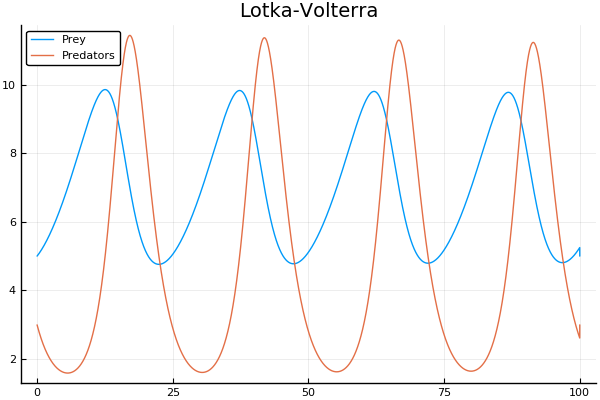

In [146]:
# Plot results
plt = plot(title = "Lotka-Volterra")
plot!(ts, res[:,1], label = "Prey")
plot!(ts, res[:,2], label = "Predators")

# **Discussion**

# **References**

- Hoffman, J. 2019. *Introduction to Scientific Computing*
- Golub, Gene H. and Van Loan, Charles F. 2013. *Matrix Computations*. 4th ed. Baltimore: John Hopkins University Press.